In [32]:
import torch
from torchvision import transforms
from dataset import NYUDataset
from custom_transforms import *
import plot_utils
%matplotlib inline

In [ ]:
#3x640x480 in dataset,   CxWxH
#480x640x3 for plotting, HxWxC
#3x480x640 for pytorch,  CxHxW  

In [33]:
bs = 16
sz = (320,240)

tfms = transforms.Compose([
    ResizeImgAndDepth(sz),
    RandomHorizontalFlip(),
    ImgAndDepthToTensor()
])

In [34]:
ds = NYUDataset('data/', tfms)

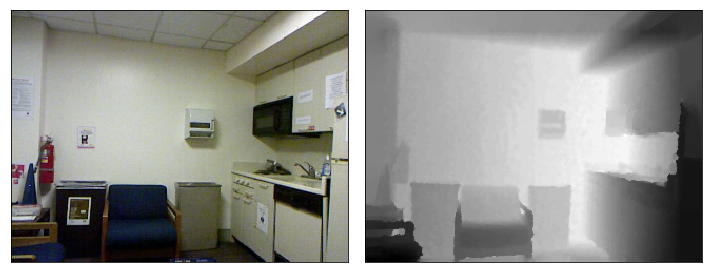

In [35]:
plot_utils.plot_image(ds[0])

In [11]:
dl = torch.utils.data.DataLoader(ds, bs)

In [23]:
sample_batch = iter(dl).next()
img, depth = sample_batch

In [24]:
img.shape

torch.Size([16, 3, 240, 320])

In [25]:
depth.shape

torch.Size([16, 240, 320])

In [ ]:
#model

In [ ]:
#training
#choose optimizer, iterate over mini batches from data loader

#n_epochs = 5
#adam, lr = 0.001